In [1]:
import spot
from spot.jupyter import display_inline
from buddy import bdd_ithvar
spot.setup()

Aliases is a feature of the HOA format that allows Boolean formulas to be named and reused to label automata.  This can be helpful to reduce the size of a file, but it can also be abused to "fake" arbritary alphabets by using an alphabet of $n$ aliases encoded over $\log_2(n)$ atomic propositions. 

Spot knows how to read HOA files containing aliases since version 2.0.  However support for producing files with aliases was only added in version 2.11.

When a HOA file containing aliases is read, the aliases are automatically expanded to define the automaton.

In [2]:
a = spot.automaton("""HOA: v1
States: 1
Start: 0
AP: 2 "p0" "p1"
Acceptance: 2 Inf(0)&Inf(1)
Alias: @a !0&!1
Alias: @b 0&!1
Alias: @c !0&1
Alias: @d 0&1
--BODY--
State: 0
[@a] 0
[@b] 0 {0}
[@c] 0 {1}
[@d] 0 {0 1}
--END--
""")
display_inline(a, a.show_storage(), per_row=2)

For more information about how to interpret the output of `show_storage()`, please see the `twagraph-internals.ipynb` notebook.

Here, observe that the edges, labeled with aliases `@a`, `@b`, `@c`, and `@d` in the input file, actually store the expanded values of the aliases.  Algorithms in Spot know nothing about the aliases, and only work with edges labeled by Boolean formulas of atomic propositions.

However since Spot 2.11, the automaton now stores an `aliases` named-property.  This property is used by the HOA printer to *attempt* to recreate edge labels using those aliases.

In [3]:
print(a.to_str('hoa'))

HOA: v1
States: 1
Start: 0
AP: 2 "p0" "p1"
acc-name: generalized-Buchi 2
Acceptance: 2 Inf(0)&Inf(1)
properties: trans-labels explicit-labels trans-acc complete
properties: deterministic
Alias: @a !0&!1
Alias: @b 0&!1
Alias: @c !0&1
Alias: @d !@c&!@b&!@a
--BODY--
State: 0
[@a] 0
[@b] 0 {0}
[@c] 0 {1}
[@d] 0 {0 1}
--END--


Additionally, passing option `@` to the Dot printer will ask it to use aliases as well.

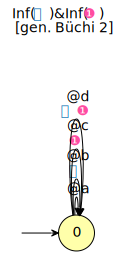

In [4]:
a.show('.@')

It should be noted that aside from input and output functions, algorithm do not care about aliases.  In particular, they will not preserve the `aliases` property while creating a new automaton:

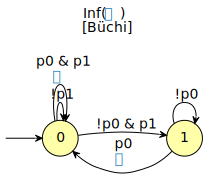

In [5]:
b = spot.degeneralize_tba(a)
b.show('.@')

This situation can be fixed by copying the aliases manually from the input automaton to the output automaton.  (This is something that `autfilt` does by default, unless `--aliases=drop` is passed.)

In [6]:
spot.set_aliases(b, spot.get_aliases(a))

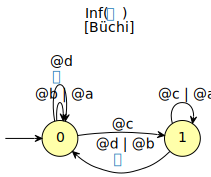

In [7]:
b.show('.@')

Notice how `p0` and `!p0` were rewritten as disjunction of aliases because no direct aliases could be found for them.  

Generaly, the display code tries to format formulas as a sum of product.  It wil recognize conjunctions and disjunctions of aliases, but if it fails, it will resort to printing the original atomic propositions (maybe mixed with aliases).

In [8]:
a = spot.automaton("""HOA: v1
States: 3
Start: 0
AP: 4 "p0" "p1" "p2" "p3"
Acceptance: 0 t
Alias: @a !0&!1
Alias: @b 0&!1
Alias: @c !0&1
Alias: @x 2&3
Alias: @y !2&!3
Alias: @z !2&3
--BODY--
State: 0
[@a&@x] 0
[@b&!@x] 1 
State: 1
[@c&@y] 0 
[!@c&!@y] 2 
State: 2
[(@a|@b)&@x] 2
[(@b|@c)&@x] 2
[@a|@b|@c] 0
--END--
""")

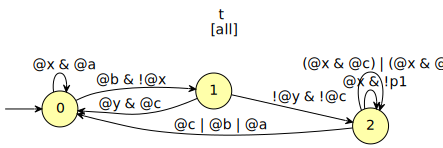

In [9]:
a.show('.@')

The above shows that the aliasing may fail to recover some non-trivial aliases combinations.  Look in particular at the loops above state 2.  `(@b|@c)&@x`, was recovered as `(@x&@c)|(@x&@b)`, but for
`(@a|@b)&@x`, which is equivalent to `!p1&p2&p3`, the code failed to translate `!p1` as `@a|@b`, so it kept `!p1`.


When the automaton uses the `synthesis-outputs` property to distinguish in and out variables (see the `synthesis.ipnb` notebook for more details), aliasing is done on inputs and output separately.

In [10]:
spot.set_synthesis_outputs(a, bdd_ithvar(a.register_ap('p2')) & bdd_ithvar(a.register_ap('p3')))

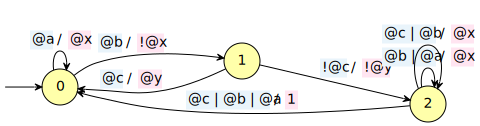

In [11]:
a.show('.@')